# Exploring European Emissions of Biogenic CO2
The aim of this notebook is to investigate the data quality of biogenic carbon dioxide emissions in Europe. Using data from the European Pollutant Release and Transfer Register (E-PRTR) and the EU ETS Transaction Log (EUTL), we will start by assessing the extent to which different countries and sectors report explicit bio-CO2 emissions (which is voluntary). We will then take a closer look at three sectors of particular interest: paper and pulp, ethanol, and heat and energy production. A synthesis of conclusions from this data exploration will be published in a policy document for European Liberal Forum (ELF) in October 2018.

The analysis is made using Python-embedded SQL to facilitate data handling as well as visualizations. Most of the data used is publicly available online. However, minor additions have been made to certain CSV files for simplicity. Please feel free to contact me with any questions (conceptual or technical) regarding the methodology, and I'll do my best to help.

<b>Anton Arbman Hansing</b><br>
Stockholm, June 2018<br>
<a href="anton.hansing@fores.se">anton.hansing@fores.se</a><br>
FORES

# START-UP CODE
This code imports basic Python packages, sets up an SQL database and imports data from <a href="www.eea.europa.eu/data-and-maps/data/member-states-reporting-art-7-under-the-european-pollutant-release-and-transfer-register-e-prtr-regulation-19">E-PRTR </a> and <a href="https://ec.europa.eu/clima/policies/ets/registry_en#tab-0-1">EU ETS</a>. Only data for the reporting year 2015 is used, since it is the most up-to-date data available in E-PRTR at the time of writing.

In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import sqlite3 as sql
encoding_type = 'ISO-8859-1'
warnings.filterwarnings("ignore")

conn = sql.connect("e-prtr.db", timeout=10)
cur = conn.cursor()

### Import data
files = {'Pol_Release_Transfer':'dbo.PUBLISH_POLLUTANTRELEASEANDTRANSFERREPORT.csv', 
             'Activity':'dbo.PUBLISH_ACTIVITY.csv',
             'Reports':'dbo.PUBLISH_UPLOADEDREPORTS.csv',
             'Pol_Transfer':'dbo.PUBLISH_POLLUTANTTRANSFER.csv',
             'Annex_Act': 'dbo.PUBLISH_EPER2EPRTR_ANNEXIACTIVITY.csv',
             'Nace_Act':'dbo.PUBLISH_EPER2EPRTR_NACEACTIVITY.csv',
             'Facility_Changes': 'dbo.PUBLISH_FACILITYID_CHANGES.csv',
             'Facility_Report': 'dbo.PUBLISH_FACILITYREPORT.csv',
             'Pol_Release': 'dbo.PUBLISH_POLLUTANTRELEASE.csv',
             'Pol_Release_Method': 'dbo.PUBLISH_POLLUTANTRELEASEMETHODUSED.csv',
             'Pol_Transfer_Method': 'dbo.PUBLISH_POLLUTANTTRANSFERMETHODUSED.csv',
             'Waste_Transfer': 'dbo.PUBLISH_WASTETRANSFER.csv',
             'Waster_Transfer_Method': 'dbo.PUBLISH_WASTETRANSFERMETHODUSED.csv'}
for name, url in files.items():
    exec(name + ' = pd.read_csv(url, encoding = encoding_type)')
    exec(name + '.to_sql(' + '\'' + name + '\'' + ', conn, if_exists = \'replace\',index=False)')

In [18]:
url = 'verified_emissions_2015_en2.csv'
EUTL_verified = pd.read_csv(url, encoding = encoding_type)
EUTL_verified.to_sql('EUTL_verified', conn, if_exists = 'replace', index=False)
url = 'nvv_data2.csv'
NVV_data = pd.read_csv(url, encoding = encoding_type)
NVV_data.to_sql('NVV_data', conn, if_exists = 'replace', index=False)

# DEFINING VIEWS
This section creates SQL views that are later used for analysis.

In [2]:
######################################################################################
### Fac_Pol_Release: View combining country reports, facilities and GHG emissions. ###
######################################################################################

s = "DROP VIEW IF EXISTS Fac_Pol_Release;"
cur.execute(s)
s = """
CREATE VIEW Fac_Pol_Release AS
SELECT * 
FROM Pol_Release_Transfer, Facility_Report, Pol_Release, Pol_Release_Method
WHERE Pol_Release_Transfer.PollutantReleaseAndTransferReportID = Facility_Report.PollutantReleaseAndTransferReportID
        AND Pol_Release.PollutantReleaseID = Pol_Release_Method.PollutantReleaseID 
        AND Facility_Report.FacilityReportID = Pol_Release.FacilityReportID
        AND PollutantGroupCode = 'GRHGAS';
"""
cur.execute(s)

############################################################
### TotCO2: View of Total CO2 emissions from facilities. ###
############################################################
    # - Only contains tuples of 'CO2' from 2015.
s = "DROP VIEW IF EXISTS TotCO2;"
cur.execute(s)
s = """
CREATE VIEW TotCO2 AS
SELECT *
FROM Fac_Pol_Release
WHERE PollutantCode = 'CO2' AND ReportingYear = 2015;
"""
cur.execute(s)

#############################################################
### FosCO2: View of fossil CO2 emissions from facilities. ###
#############################################################
    # Saves TotalQuantity as FossilQuantity where 'CO2 EXCL BIOMASS'.

s = "DROP VIEW IF EXISTS FosCO2;"
cur.execute(s)
s = """
CREATE VIEW FosCO2 AS
SELECT FacilityID, TotalQuantity AS FossilQuantity
FROM Fac_Pol_Release
WHERE PollutantCode = 'CO2 EXCL BIOMASS' AND ReportingYear = 2015;
"""
cur.execute(s)

###########################################################
### BioCO2: View of biogenic emissions from facilities. ###
###########################################################
    # Joins TotCO2 (left) with FosCO2 on FacilityID
    # Good idea, since TotCO2 has only 'CO2' and FosCO2 has only 'CO2 EXCL BIOMASS'
    # FossilQuantity: becomes NULL if 'CO2 EXCL BIOMASS' is unavailable, otherwise 'CO2 EXCL BIOMASS'-quantity.
            # in other words, FossilQ may be fossil or NULL
    # BioQuantity becomes NULL if 'CO2 EXCL BIOMASS' is unavailable, otherwise ('CO2')-('CO2 EXCL BIOMASS').

s = """
DROP VIEW IF EXISTS BioCO2;
"""
cur.execute(s)
s = """
CREATE VIEW BioCO2 AS
SELECT *,
        FosCO2.FossilQuantity,
        (TotCO2.TotalQuantity - FosCO2.FossilQuantity) as BioQuantity,
        ((TotCO2.TotalQuantity - FosCO2.FossilQuantity)/TotCO2.TotalQuantity) as BioPerc
FROM TotCO2 LEFT JOIN FosCO2
ON TotCO2.FacilityID = FosCO2.FacilityID;
"""
cur.execute(s)

# EXPLORING FACILITIES
Definition of further views to explore individual facilities and sectors.

In [3]:
######################################################################################################################
### Sector_Emissions: View of number of facilities and emissions (fossil/bio) per (country, activity) combination. ###
######################################################################################################################
s = "DROP VIEW IF EXISTS Sector_Emissions;"
cur.execute(s)

s = """
CREATE VIEW Sector_Emissions AS
SELECT CountryName as Country,
        NACEMainEconomicActivityCode AS Act_Code,
        NACEMainEconomicActivityName AS Act_Name,
        COUNT(*) AS Nat_Sector_Reports,
        SUM(TotalQuantity) / 1000000000.0 AS Total_Sum,
        SUM(FossilQuantity) / 1000000000.0 AS Fossil_Sum,
        SUM(BioQuantity) / 1000000000.0 AS Bio_Sum,
        100.0*SUM(BioQuantity) / (SUM(TotalQuantity)*1.0) AS BioCO2_perc,
        SUM(CASE WHEN BioQuantity > 0.1 THEN 1 ELSE 0 END) AS Bio_More_Than_0,
        ROUND(100.0*SUM(CASE WHEN BioQuantity > 0.1 THEN 1 ELSE 0 END) / (COUNT(*)*1.0), 2) AS Bio_Rep_Perc1,
        SUM(CASE WHEN BioQuantity IS NOT NULL THEN 1 ELSE 0 END) AS Bio_Is_Not_Null,
        ROUND(100.0*SUM(CASE WHEN BioQuantity IS NOT NULL THEN 1 ELSE 0 END) / (COUNT(*)*1.0), 2) AS Bio_Rep_Perc2
FROM BioCO2
GROUP BY CountryName, NACEMainEconomicActivityCode, NACEMainEconomicActivityName
ORDER BY SUM(TotalQuantity) DESC;
"""
cur.execute(s)

########################################################################################################
### Paper_Pulp_Fac: Facilities of pulp or paper production with total emissions of > 0.5 Mt in 2015. ###
########################################################################################################

s = "DROP VIEW IF EXISTS Paper_Pulp_Fac;"
cur.execute(s)
s = """
CREATE VIEW Paper_Pulp_Fac AS
SELECT *
FROM BioCO2
WHERE NACEMainEconomicActivityName = 'Manufacture of pulp'
        OR NACEMainEconomicActivityName = 'Manufacture of paper and paperboard'
        AND TotalQuantity / 1000000000.0 > 0.5
ORDER BY TotalQuantity DESC;
"""
cur.execute(s)

In [15]:
### The dataframe 'reported' contains all paper/pulp facilities reporting more than 0.5 Mt bio-CO2 to E-PRTR.
### 'unreported' contains al facilities emitting more than 0.5 Mt in 2015, without reporting bio-CO2.
### According to EUTL data, only ID=6221 had less than 0.5 Mt bio-CO2 emissions, despite total CO2 of more than 0.5 Mt.

########################################################################################################
### Estimated_Bio: View containing paper and pulp facilities and their estimated bio-CO2 emissions. ####
########################################################################################################
s = "DROP VIEW IF EXISTS Estimated_Bio;"
cur.execute(s)
s = """
CREATE VIEW Estimated_Bio as
SELECT PRTR_ID, Comment, est_bio
FROM EUTL_Verified
WHERE Comment = 'paper';
"""
cur.execute(s)

s = """
SELECT ParentCompanyName as Company,
        FacilityID as ID,
        FacilityName as Facility,
        CountryName,
        NACEMainEconomicActivityName as Sector,
        TotalQuantity / 1000000000.0 as TotQ, 
        FossilQuantity / 1000000000.0 as FosQ,
        est_bio as Est_BioQ,
        ROUND(100.0*BioQuantity / TotalQuantity, 0) as BioPerc,
        Lat,
        Long
FROM Paper_Pulp_Fac, Estimated_Bio
WHERE Est_BioQ > 0.5
        AND PRTR_ID = FacilityID
ORDER BY TotalQuantity DESC;
"""
unreported = pd.read_sql_query(s, conn)

s = """
SELECT ParentCompanyName as Company,
        FacilityID as ID,
        FacilityName as Facility,
        CountryName,
        NACEMainEconomicActivityName as Sector,
        TotalQuantity / 1000000000.0 as TotQ, 
        FossilQuantity / 1000000000.0 as FosQ,
        BioQuantity / 1000000000.0 as BioQ,
        ROUND(100.0*BioQuantity / TotalQuantity, 0) as BioPerc,
        Lat,
        Long
FROM Paper_Pulp_Fac
WHERE BioQ > 0.5
ORDER BY TotalQuantity DESC;
"""
reported = pd.read_sql_query(s, conn)

out_file = 'paper_pulp_facilities.csv'
reported.to_csv(out_file, header=True, mode = 'w', encoding='utf8')
unreported.to_csv(out_file, header=False, mode = 'a', encoding='utf8')

In [24]:
##############################################################################################
### NVV_Fac: View containing facilities with their PRTR-ID and Bio-CO2 emissions in 2017. ####
##############################################################################################
s = "DROP VIEW IF EXISTS NVV_Fac;"
cur.execute(s)
s = """
CREATE VIEW NVV_Fac as
SELECT prtr_id, bioCO2
FROM NVV_data;
"""
cur.execute(s)
s = """
SELECT FacilityName, BioCO2 as BioQ, Lat, Long
FROM NVV_Fac, BioCO2
WHERE PRTR_ID = FacilityID and
        (NACEMainEconomicActivityName LIKE '%paper%' or NACEMainEconomicActivityName LIKE '%pulp%');
"""
se_paper_2017 = pd.read_sql_query(s, conn)

s = """
SELECT FacilityName, BioCO2 as BioQ, Lat, Long
FROM NVV_Fac, BioCO2
WHERE PRTR_ID = FacilityID and
        not (NACEMainEconomicActivityName LIKE '%paper%' or NACEMainEconomicActivityName LIKE '%pulp%');
"""
se_chp_2017 = pd.read_sql_query(s, conn)
#se_paper_2017

In [4]:
### Code snippet to search for facilities. Parameters can be specified in the 'WHERE' clause.
s = """
SELECT ParentCompanyName as Company,
        FacilityID as ID,
        FacilityName as Facility,
        CountryName,
        NACEMainEconomicActivityName as Sector,
        TotalQuantity / 1000000000.0 as TotQ, 
        FossilQuantity / 1000000000.0 as FosQ,
        BioQuantity / 1000000000.0 as BioQ,
        ROUND(100.0*BioQuantity / TotalQuantity, 0) as BioPerc,
        Lat,
        Long
FROM BioCO2
WHERE CountryName = 'Sweden' and BioQ > 0.3 
ORDER BY BioQ DESC
;
"""
df = pd.read_sql_query(s, conn)
#df

# SECTORS / ACTIVITIES

In [8]:
### Query of the sectors reporting the biggest bio-CO2 emissions.
## COLUMNS
# BioQ: sum of reported biogenic CO2 in sector.
# FosQ: sum of reported fossil CO2 in sector, in countries also reporting BioQ.
# BioPerc: Biogenic proportion of CO2 emissions in countries reporting bio-CO2 (%).
# TotQ2: total quantity from countries not reporting biomass CO2.
# projBioCO2: projected biomass CO2 from countries not reporting bio-CO2 explicitly (linear estimate).

s = """
SELECT NACEMainEconomicActivityCode AS NaceCode,
        NACEMainEconomicActivityName AS Name,
        ROUND(SUM(FossilQuantity) / 1000000000.0, 2) AS FosQ,
        ROUND(SUM(BioQuantity) / 1000000000.0, 2) AS BioQ,
        ROUND(100.0*SUM(BioQuantity) / (SUM(FossilQuantity)+SUM(BioQuantity)), 0) AS BioPerc,
        ROUND((SUM(TotalQuantity)-SUM(FossilQuantity)-SUM(BioQuantity)) / 1000000000.0, 2) AS UnknownQ,
        ROUND( SUM(BioQuantity) / (SUM(FossilQuantity)+SUM(BioQuantity))
                    * (SUM(TotalQuantity)-SUM(FossilQuantity)-SUM(BioQuantity)) / 1000000000.0, 2) as projBioCO
FROM BioCO2
GROUP BY NACEMainEconomicActivityCode, NACEMainEconomicActivityName
HAVING ROUND(SUM(BioQuantity) / 1000000000.0, 2) > 0.2
ORDER BY SUM(BioQuantity) DESC;
"""
sectors = pd.read_sql_query(s, conn)
#sectors

In [61]:
### Query of countries and reporting practices for CHP, paper and pulp industries.
s = """
SELECT CountryName,
        NACEMainEconomicActivityName as Sector,
        COUNT(*) as Reports,
        COUNT(BioQuantity) as Bio_Reports,
        SUM(TotalQuantity) / 1000000000.0 as TotQ,
        SUM(BioQuantity) / 1000000000.0 as BioQ,
        ROUND(100*SUM(BioQuantity)/SUM(TotalQuantity), 1) as BioPerc
FROM BioCO2
WHERE (NACEMainEconomicActivityName = 'Manufacture of pulp'
        OR NACEMainEconomicActivityName = 'Manufacture of paper and paperboard'
        OR NACEMainEconomicActivityName LIKE '%steam%')
        AND TotalQuantity > 0.5*1000000000.0
GROUP BY CountryName, NACEMainEconomicActivityName
ORDER BY TotQ DESC, CountryName, NACEMainEconomicActivityName;
"""
se = pd.read_sql_query(s, conn)
#se.to_csv('country_sector.csv')
#se

In [ ]:
### Table of countries and reporting practices for all industries in countries with at least one paper or pulp facility (remove?).
s = """
SELECT CountryName,
        "All" as Sector,
        COUNT(*) as Reports,
        COUNT(BioQuantity) as Bio_Reports,
        SUM(TotalQuantity) / 1000000000.0 as TotQ,
        SUM(BioQuantity) / 1000000000.0 as BioQ,
        ROUND(100*SUM(BioQuantity)/SUM(TotalQuantity), 1) as BioPerc
FROM BioCO2
WHERE   TotalQuantity > 0.5*1000000000.0
        AND CountryName IN (SELECT CountryName
                                FROM BioCO2
                                WHERE NACEMainEconomicActivityName = 'Manufacture of pulp'
                                        OR NACEMainEconomicActivityName = 'Manufacture of paper and paperboard'
                                        AND TotalQuantity > 0.5*1000000000.0)
GROUP BY CountryName
ORDER BY CountryName;
"""
se = pd.read_sql_query(s, conn)
#se.to_csv('country_sector.csv', mode='a', header=False)
#se

In [25]:
### Swedish facilities of interest.
s = """SELECT ParentCompanyName as Company,
        FacilityID as ID,
        FacilityName as Facility,
        CountryName,
        NACEMainEconomicActivityName as Sector,
        TotalQuantity / 1000000000.0 as TotQ, 
        FossilQuantity / 1000000000.0 as FosQ,
        BioQuantity / 1000000000.0 as BioQ,
        ROUND(100.0*BioQuantity / TotalQuantity, 0) as BioPerc,
        Lat,
        Long
FROM BioCO2
WHERE CountryCode = 'SE' and (BioQ > 0.5 or facilityname like '%etanol%' or facilityname like '%nym%')
        and (sector = 'Manufacture of pulp' or sector = 'Manufacture of paper and paperboard')
ORDER BY BioQ DESC;
"""
se_paper = pd.read_sql_query(s, conn)
s = """SELECT ParentCompanyName as Company,
        FacilityID as ID,
        FacilityName as Facility,
        CountryName,
        NACEMainEconomicActivityName as Sector,
        TotalQuantity / 1000000000.0 as TotQ, 
        FossilQuantity / 1000000000.0 as FosQ,
        BioQuantity / 1000000000.0 as BioQ,
        ROUND(100.0*BioQuantity / TotalQuantity, 0) as BioPerc,
        Lat,
        Long
FROM BioCO2
WHERE CountryCode = 'SE' and facilityname like '%etanol%'
ORDER BY BioQ DESC;
"""
se_etanol = pd.read_sql_query(s, conn)
s = """SELECT ParentCompanyName as Company,
        FacilityID as ID,
        FacilityName as Facility,
        CountryName,
        NACEMainEconomicActivityName as Sector,
        TotalQuantity / 1000000000.0 as TotQ, 
        FossilQuantity / 1000000000.0 as FosQ,
        BioQuantity / 1000000000.0 as BioQ,
        ROUND(100.0*BioQuantity / TotalQuantity, 0) as BioPerc,
        Lat,
        Long
FROM BioCO2
WHERE CountryCode = 'SE' and (TotQ > 0.5 or facilityname like '%etanol%' or facilityname like '%nym%')
        and (sector = 'Steam and air conditioning supply' or sector = 'Production of electricity')
ORDER BY BioQ DESC;
"""
se_chp = pd.read_sql_query(s, conn)

#print(se_paper['Facility'])
#print(se_etanol['Facility'])
#print(se_chp['Facility'])
#se

# VISUALIZATIONS
This section generates various map and graph visualizations of facilities with large emissions.

In [22]:
### Import map datasets.
World = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
### not_in_EU is group of countries on the European continent not reporting emissions to E-PRTR.
not_in_EU = ['Russia', 'Albania', 'Armenia', 'Belarus', 'Gibraltar', 'Kosovo', 'Macedonia', 'Turkey', 'Ukraine']
Europe = World.loc[(World['continent'] == 'Europe')]
Sweden = World.loc[(World['name'] == 'Sweden')]
EU = Europe
notEU = gpd.GeoDataFrame()
for ctry in not_in_EU:
    EU = EU[EU['name'] != ctry]
    notEU = notEU.append(World[World['name'] == ctry])

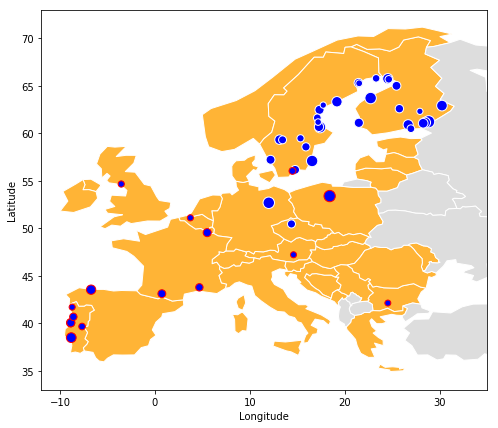

In [70]:
### Plot of European paper and pulp facilities emitting more biogenic CO2 than 0.5 Mt in 2015.
### The marker size represents the quantity of biogenic emissions.
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
repX = reported['Long']
repY = reported['Lat']
repSize = reported['BioQ']
repSector = reported['Sector']
unrepX = unreported['Long']
unrepY = unreported['Lat']
unrepSize = unreported['Est_BioQ']
unrepSector = unreported['Sector']
c = {'EU': '#FFB436', 'notEU': '#DDDDDD', 'edge': 'White', 'rep': '#0000FF', 'unrep':'#0000FF', 'rep_e': 'White', 'unrep_e': 'Red'}
EU.plot(ax=ax, color=c['EU'], edgecolor=c['edge'])
notEU.plot(ax=ax, color=c['notEU'], edgecolor=c['edge'])
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.axis([-12, 35, 33, 73])
scale = 70.0
repScat = plt.scatter(repX, repY, marker='o', color=c['rep'], edgecolors=c['rep_e'], s=repSize*scale)
unrepScat = plt.scatter(unrepX, unrepY, marker='o', color=c['unrep'], edgecolors=c['unrep_e'], s=unrepSize*scale)
small = plt.scatter([],[], s=0.5*scale, color='White', edgecolors='Black')
large = plt.scatter([],[], s=2.0*scale, color='White', edgecolors='Black')
labels = ('Reported in E-PRTR', 'Unreported in E-PRTR', '0.5 Mt', '2.0 Mt')
plt.legend((repScat, unrepScat, small, large), labels, loc=2, frameon=False, fontsize=11)
filename = 'paper_pulp_all'
#plt.savefig(filename + '.eps'); plt.savefig(filename + '.png'); 

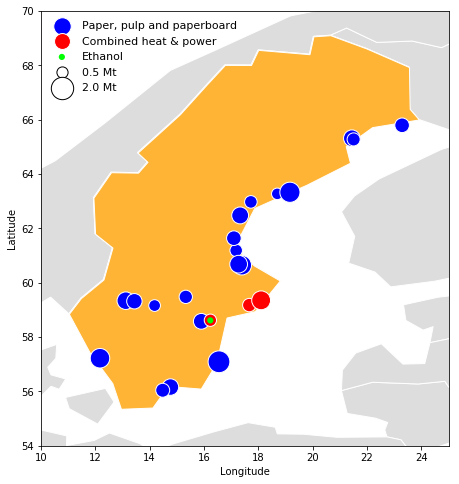

In [26]:
### Swedish facilities reporting more than 0.5 Mt of bio-CO2 in 2017.
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
paperX = se_paper_2017['Long']
paperY = se_paper_2017['Lat']
paperSize = se_paper_2017['BioQ'] # difference bioQ-TotQ negligible
chpX = se_chp_2017['Long']
chpY = se_chp_2017['Lat']
chpSize = se_chp_2017['BioQ']
etanolX = se_etanol['Long']
etanolY = se_etanol['Lat']
etanolSize = se_etanol['BioQ']
c = {'SE': '#FFB436', 'notSE': '#DDDDDD', 'edge': 'White', 
     'paper': '#0000FF', 'chp':'#FF0000', 'etanol': '#00FF00',
     'paper_e': 'White', 'chp_e': 'White', 'etanol_e': 'None'}
EU.plot(ax=ax, color=c['notSE'], edgecolor=c['edge'])
Sweden.plot(ax=ax, color=c['SE'], edgecolor=c['edge'])
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.axis([10, 25, 54, 70])
scale = 250.0
paperScat = plt.scatter(paperX, paperY, marker='o', color=c['paper'], edgecolors=c['paper_e'], s=paperSize*scale)
chpScat = plt.scatter(chpX, chpY, marker='o', color=c['chp'], edgecolors=c['chp_e'], s=chpSize*scale)
etanolScat = plt.scatter(etanolX, etanolY, marker='o', color=c['etanol'], edgecolors=c['etanol_e'], s=etanolSize*scale)
small = plt.scatter([],[], s=0.5*scale, color='White', edgecolors='Black')
large = plt.scatter([],[], s=2.0*scale, color='White', edgecolors='Black')
labels = ('Paper, pulp and paperboard', 'Combined heat & power', 'Ethanol', '0.5 Mt', '2.0 Mt')
plt.legend((paperScat, chpScat, etanolScat, small, large), labels, loc=2, frameon=False, fontsize=11)
filename = 'se_point_sources17'
se_paper_2017.to_csv(filename + '.csv', header=True, mode = 'w', encoding='utf8')
se_chp_2017.to_csv(filename + '.csv', header=False, mode = 'a', encoding='utf8')
se_etanol.to_csv(filename + '.csv', header=False, mode = 'a', encoding='utf8')
#plt.savefig(filename + '.eps'); plt.savefig(filename + '.png'); 
plt.show()

NameError: name 'se_paper' is not defined

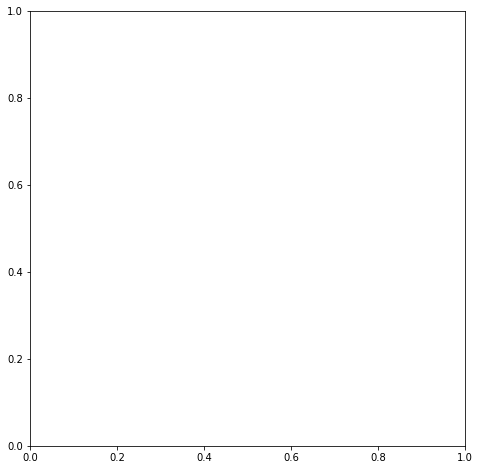

In [20]:
### OLD: Swedish facilities with > 0.5 Mt bio-CO2 emissions in 2015.
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
paperX = se_paper['Long']
paperY = se_paper['Lat']
paperSize = se_paper['TotQ'] # difference bioQ-TotQ negligible
chpX = se_chp['Long']
chpY = se_chp['Lat']
chpSize = se_chp['TotQ']
etanolX = se_etanol['Long']
etanolY = se_etanol['Lat']
etanolSize = se_etanol['BioQ']
c = {'SE': '#FFB436', 'notSE': '#DDDDDD', 'edge': 'White', 
     'paper': '#0000FF', 'chp':'#FF0000', 'etanol': '#00FF00',
     'paper_e': 'White', 'chp_e': 'White', 'etanol_e': 'None'}
EU.plot(ax=ax, color=c['notSE'], edgecolor=c['edge'])
Sweden.plot(ax=ax, color=c['SE'], edgecolor=c['edge'])
title = 'Paper and pulp facilities with yearly bio-CO2 emissions higher than 0.5 Mt (2015)'
#plt.title(title)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.axis([10, 25, 54, 70])
scale = 150.0
paperScat = plt.scatter(paperX, paperY, marker='o', color=c['paper'], edgecolors=c['paper_e'], s=paperSize*scale)
chpScat = plt.scatter(chpX, chpY, marker='o', color=c['chp'], edgecolors=c['chp_e'], s=chpSize*scale)
etanolScat = plt.scatter(etanolX, etanolY, marker='o', color=c['etanol'], edgecolors=c['etanol_e'], s=etanolSize*scale)
small = plt.scatter([],[], s=0.5*scale, color='White', edgecolors='Black')
large = plt.scatter([],[], s=2.0*scale, color='White', edgecolors='Black')
labels = ('Paper, pulp and paperboard', 'Combined heat & power', 'Ethanol', '0.5 Mt', '2.0 Mt')
plt.legend((paperScat, chpScat, etanolScat, small, large), labels, loc=2, frameon=False, fontsize=11)
filename = 'se_point_sources'
#plt.savefig(filename + '.eps'); plt.savefig(filename + '.png'); 
plt.show()

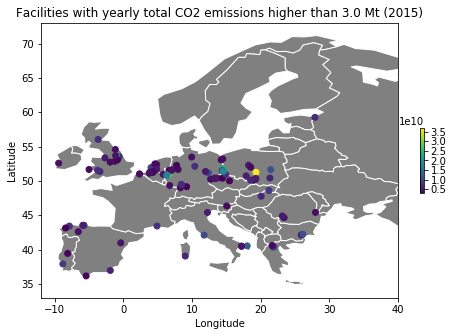

In [71]:
### Plot of European facilities emitting more total CO2 than 'threshold' value.
threshold = 3.0*1000000000.0
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
Europe.plot(ax=ax, color='Gray', edgecolor='White')
moreThan = pd.read_sql_query("SELECT * FROM BioCO2 WHERE TotalQuantity > " + str(threshold) + ";", conn)
x = moreThan['Long']
y = moreThan['Lat']
qCO2 = moreThan['TotalQuantity']
title = 'Facilities with yearly total CO2 emissions higher than ' + str(threshold /(10.0**9)) + ' Mt (2015)'
plt.title(title)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.axis([-12, 40, 33, 73])
plt.scatter(x, y, marker='o', c=qCO2)
plt.colorbar(shrink=0.15)
#plt.savefig('thebio05Mt.png')
plt.show()

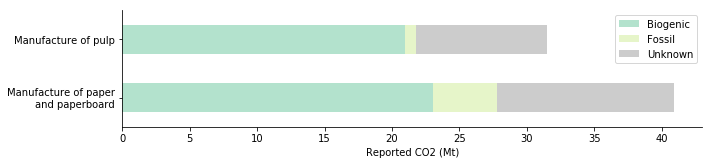

In [16]:
### Fraction of emissions of reported origin for pulp and paper industries.
color_scale = 'Pastel2' # more color maps can be found at matplotlib.org/examples/color/colormaps_reference.html
pp = sectors[(sectors['Name'] == 'Manufacture of pulp') | (sectors['Name'] == 'Manufacture of paper and paperboard')]
pp2 = pp[['Name', 'BioQ', 'FosQ', 'UnknownQ']]
pp3 = pp2.rename(index=str, columns={'BioQ': 'Biogenic', 'FosQ': 'Fossil', 'UnknownQ': 'Unknown'})
pp3.ix[0, 'Name'] = 'Manufacture of paper' + '\n' + 'and paperboard'
ax = pp3.plot.barh(x = 'Name', stacked=True, figsize=(10, 2.4), colormap=color_scale)
xlabel = 'Reported CO2 (Mt)'
ylabel = ''
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig = ax.get_figure()
plt.tight_layout()
filename = 'pp_sectors.csv'
pp3.to_csv(filename, header=True, mode = 'w', encoding='utf8')
#fig.savefig(filename + '.png', transparent=True); fig.savefig(filename + '.eps', transparent=True); 

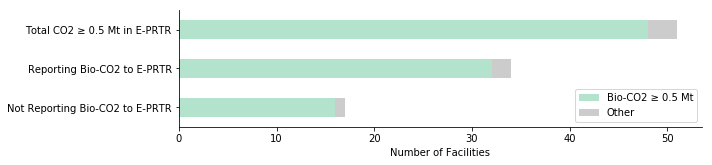

In [19]:
### Diagram of the biogenic emissions of paper/pulp facilities reporting or not reporting bio-CO2.
color_scale = 'Pastel2' # more color maps can be found at matplotlib.org/examples/color/colormaps_reference.html
d = {'Other': [1, 2, 3], 'Bio-CO2 ≥ 0.5 Mt': [16, 32, 48]}
df = pd.DataFrame(data=d)
ax = df.plot.barh(stacked=True, figsize=(10, 2.4), colormap=color_scale)
x_tags = ('Not Reporting Bio-CO2 to E-PRTR',
          'Reporting Bio-CO2 to E-PRTR',
          'Total CO2 ≥ 0.5 Mt in E-PRTR')
ax.set_yticklabels(x_tags)
xlabel = 'Number of Facilities'
ylabel = ''
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig = ax.get_figure()
plt.tight_layout()
filename = 'pp_facilities'
df.to_csv(filename + '.csv', header=True, mode = 'w', encoding='utf8')
#fig.savefig(filename + '.png', transparent=True); fig.savefig(filename + '.eps', transparent=True); 

# METHODS
Quick check of which reporting methods are the most common in E-PRTR.

In [75]:
s = """
SELECT MethodTypeCode, MethodTypeName, (SUM(BioQuantity)/1000000000.0) AS bioQ, (SUM(TotalQuantity)/1000000000.0) AS totQ
FROM BioCO2
GROUP BY MethodTypeCode, MethodTypeName
ORDER BY totQ DESC;
"""
CO2_Methods = pd.read_sql_query(s, conn)
CO2_Methods

,MethodTypeCode,MethodTypeName,bioQ,totQ
0,ETS,Guidelines for the monitoring and reporting of...,30.670959,906.832
1,OTH,Other measurement/calculation methodology,18.863380,289.040
2,PER,Measurement/Calculation Methodology already pr...,25.537829,238.552
3,SSC,European-wide sector specific calculation method,1.291300,105.061
4,NRB,National or regional binding measurement/calcu...,5.088563,102.239
5,MAB,Mass balance method which is accepted by the c...,3.022330,45.424
6,IPCC,IPCC Guidelines,0.864100,22.220
7,CEN/ISO,Internationally approved measurement standard,2.733300,16.147
8,None,None,0.821760,11.012
9,CRM,Measurement methodology for the performance of...,0.168000,5.102
